# Creating a basketball mini map using homography transformations

Author Stephan Janssen (sja@devoxx.com)

See also related [article on LinkedIn](https://www.linkedin.com/pulse/journey-towards-creating-basketball-mini-map-stephan-janssen/) and result on [YouTube](https://www.youtube.com/watch?v=tpavRDeDlTI).

We still need to identify the players per team which can be achieved using colour detection, that's not too difficult.

Improvements or suggestions are always welcome!

# Install detectron2

In [0]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

In [0]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect

# Some basic setup

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

In [0]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/3DVideoFrame.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [5]:
cfg = get_cfg()

cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

predictor = DefaultPredictor(cfg)

players_output = predictor(im)

WARNING [12/27 18:52:43 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [0]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
instances = players_output["instances"]
print(instances)
pred_boxes = instances.get("pred_boxes")
pred_classes = instances.get("pred_classes")
print(pred_boxes)
print(pred_classes)

In [0]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
v = v.draw_instance_predictions(players_output["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
# Four corners of the 3D court 
# Start top-left corner and go anti-clock wise
src_pts = np.array([
        [0,711],
        [954,821],
        [1919,762],
        [1919,631],
        [1493,525],
        [493,505],
        [4,608]
    ])   

im_poly = im.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[255,0,0], thickness=2)

cv2_imshow(im_poly)

In [0]:
# Use the boxes info from the tensor prediction result
#
# x1,y1 ------
# |          |
# |          |
# |          |
# --------x2,y2
#
from shapely.geometry import Point, Polygon

def drawPlayers(im, pred_boxes, showResult=False):
  color = [255, 0, 0]   
  thickness = 1
  radius = 1

  i  = 0
  for box in pred_boxes:
    
    # Include only class Person
    if pred_classes[i] == 0:  
        
      x1 = int(box[0])
      y1 = int(box[1])
      x2 = int(box[2])
      y2 = int(box[3])

      xc = x1 + int((x2 - x1)/2)
      player_pos1 = (xc - 1, y2)
      player_pos2 = (xc + 1, y2 + 1)

      court = Polygon(src_pts)

      # Draw only players that are within the basketball court
      if Point(player_pos1).within(court):
        if showResult:
          print("[% 3d, % 3d]" %(xc, y2))

        cv2.rectangle(im, player_pos1, player_pos2, color, thickness)
        i = i + 1

  if showResult:
    cv2_imshow(im)


drawPlayers(im, pred_boxes, True)

In [0]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/2DCourt1920x1080.jpg -O court.jpg

In [0]:
img_dst = cv2.imread('./court.jpg')

# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_pts = np.array([
      [144,  1060],  # LEFT BOTTOM
      [969,  1065],  # MIDDLE BOTTOM
      [1769, 1063],  # RIGHT BOTTOM
      [1885, 875],   # TOP BOTTOM RIGHT  (4 o'clock)
      [1882,  49],   # TOP RIGHT
      [50,    43],   # TOP LEFT
      [50,    871]   # TOP - BOTTOM LEFT (7 o'clock)
    ])   

cv2.polylines(img_dst, [dst_pts], isClosed=True, color=[255,0,0], thickness=2)
cv2_imshow(img_dst)

In [0]:
def homographyTransform(im, showResult=False):

  # Calculate Homography
  h, status = cv2.findHomography(src_pts, dst_pts)
  img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
  
  if showResult:
    cv2_imshow(img_out)

  return img_out  

# Try out
img_out = homographyTransform(im, True)  

In [0]:
def getPlayersMask(im):
  lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
  upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
  mask = cv2.inRange(im, lower_range, upper_range)     # Create a mask with range
  result = cv2.bitwise_and(im, img_out, mask = mask)   # Performing bitwise and operation with mask in img variable
  # cv2_imshow(result)                              

  return cv2.inRange(result, lower_range, upper_range)  
  
# Try out  
mask = getPlayersMask(img_out)    
cv2_imshow(mask)

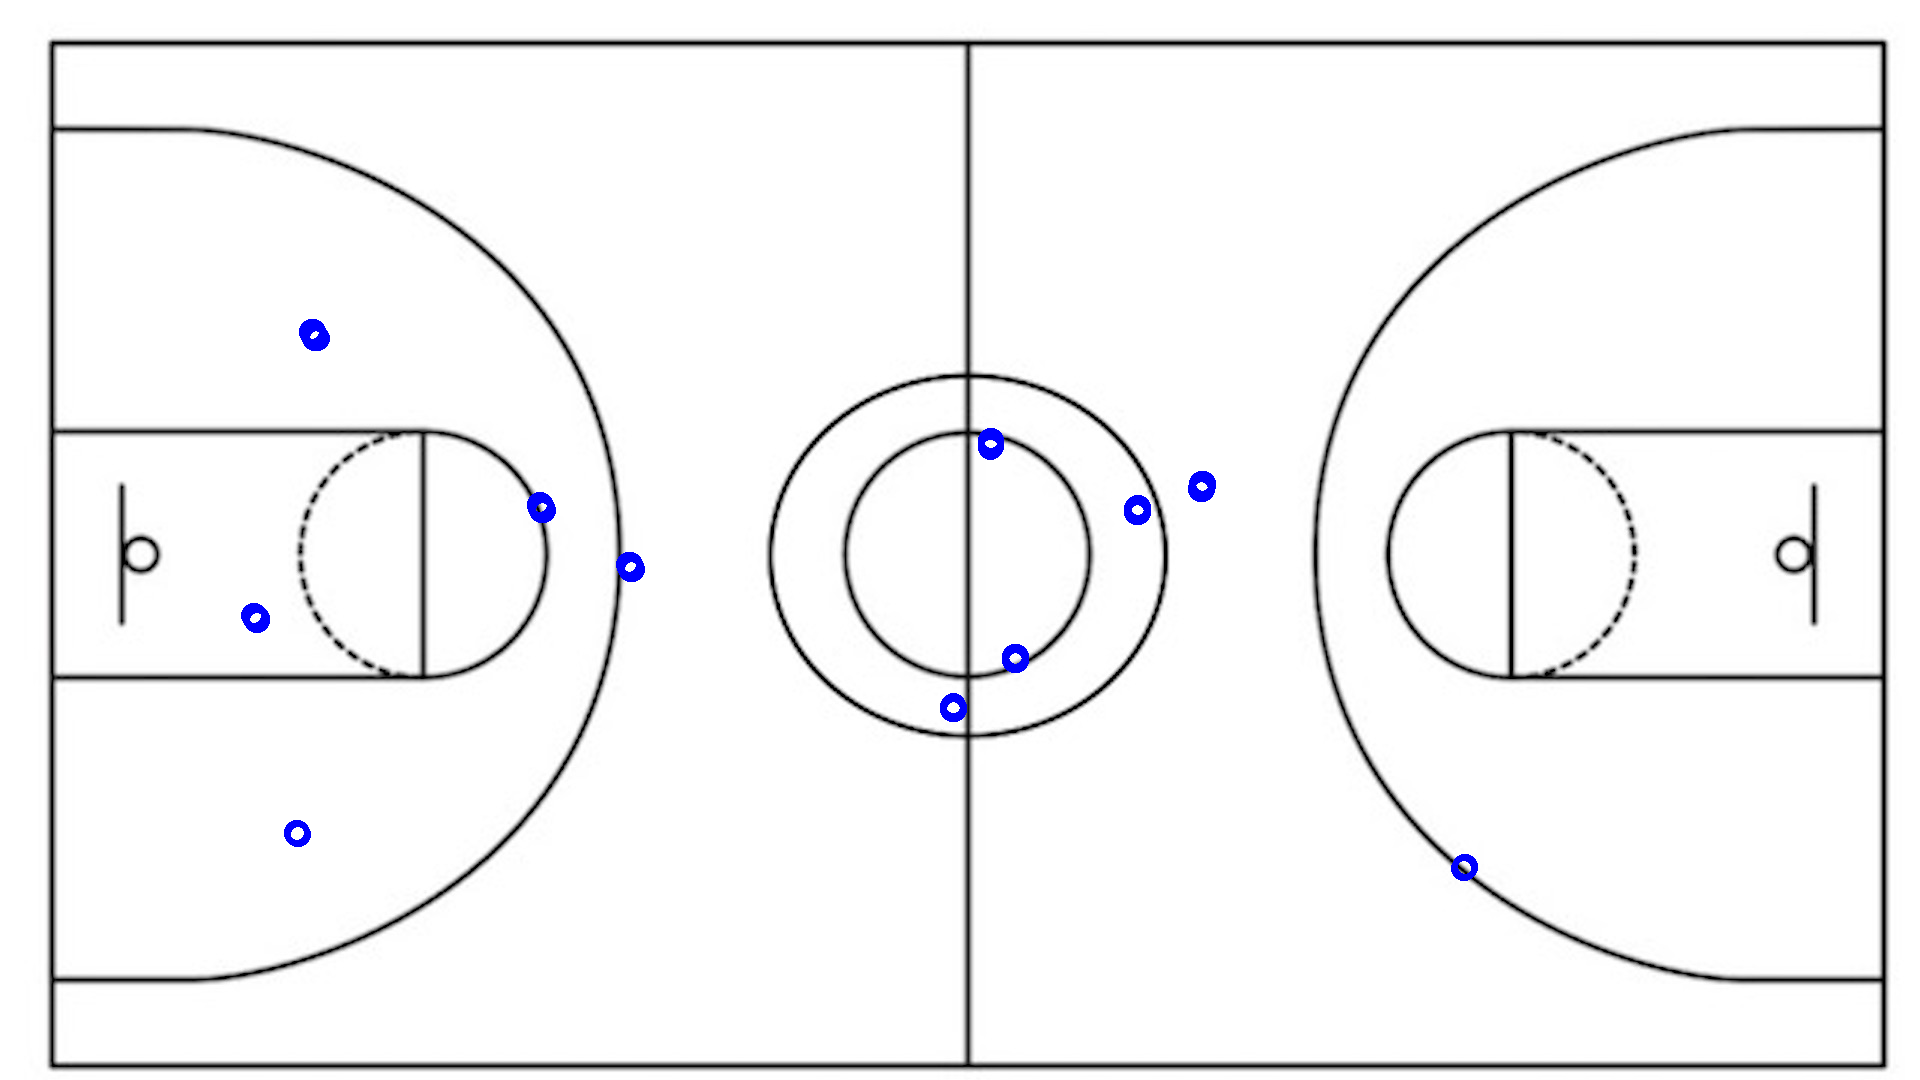

In [21]:
def drawPlayersOnCourt(im, mask):

  #get all non zero values
  coord = cv2.findNonZero(mask)

  # Radius of circle 
  radius = 10
    
  # Blue color in BGR 
  color = (255, 0, 0) 

  # Line thickness of 2 px 
  thickness = 3

  for pos in coord:
    center_coordinates = (pos[0][0], pos[0][1])
    cv2.circle(im, center_coordinates, radius, color, thickness) 

  return im

# Try out
court_img = cv2.imread('./court.jpg')
result = drawPlayersOnCourt(court_img, mask)
cv2_imshow(result)

Now lets create a mini-map based on a 30 seconds basketball game.

In [0]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/mini-map-game-input.mp4 -O video.mp4
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/2DCourt1920x1080.jpg -O court.jpg

In [0]:
import time
import progressbar
from time import sleep
from collections import deque
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import GenericMask

vs = cv2.VideoCapture("./video.mp4")
totalFrames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))

grabbed = True
currentFrame = 0
start = time.time()
writer = None
status = None

bar = progressbar.ProgressBar(maxval=totalFrames, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()

court_img = cv2.imread('./court.jpg')

old_result = None;

# loop over frames from the video file stream (207)
while grabbed:     
  
  # read the next frame from the file
  (grabbed, frame) = vs.read()

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter("mini-map-output.mp4", fourcc, 24, (court_img.shape[1], court_img.shape[0]), True)

  if grabbed: 

    # Get player positions
    outputs = predictor(frame)  
    instances = outputs["instances"].to("cpu")
    boxes = instances.get("pred_boxes")
    # print(boxes)

    court = court_img.copy()

    # Draw players on video frame
    drawPlayers(frame, boxes, False)
    
    img_out = homographyTransform(frame, False)
    # cv2_imshow(img_out)

    mask = getPlayersMask(img_out)
    # cv2_imshow(mask)

    result = drawPlayersOnCourt(court, mask)

    old_result = result.copy()  

    writer.write(result)

    currentFrame += 1
    bar.update(currentFrame)
  
  else:
      grabbed = False

writer.release()
vs.release()
bar.finish()

end = time.time()
elap = (end - start)
print("[INFO] process took {:.4f} seconds".format(elap))

print("Video created")